In [1]:
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import arviz as az

In [2]:
az.style.use('arviz-white')

# Probabilistic Programming

This post is based on an excerpt from the second chapter of the book that I have slightly adapted so it's easier to read without having read the first chapter. 


## Bayesian Inference

Bayesian statistics is conceptually very simple; we have _the knowns_ and _the unknowns_; we use Bayes' theorem to condition the latter on the former. If we are lucky, this process will reduce the uncertainty about _the unknowns_.

Generally, we refer to _the knowns_ as **data** and treat it like a constant, and __the unknowns__ as **parameters** and treat them as probability distributions. In more formal terms, we assign probability distributions to unknown quantities. Then, we use Bayes' theorem to combine the prior probability distribution and the data to get the posterior distribution.


$$p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{p(y)}$$

Here $\theta$ represents the parameters in our model, generally this are the quantities we want to learn, $y$ represents the data.

Each term in the Bayes Theorem has it's own name:

* $p(\theta \mid y)$: posterior
* $p(y \mid \theta)$: likelihood
* $p(\theta)$: prior
* $p(y)$: marginal likelihood

The prior distribution should reflect what we know about the value of the parameter before seeing the data $y$. If we know nothing, like Jon Snow, we could use _flat_ priors that do not convey too much information. In general, we can do better than flat priors.

The likelihood is how we introduce data in our analysis. It is an expression of the plausibility of the data given the parameters.

The posterior distribution is the result of the Bayesian analysis and reflects all that we know about a problem (given our data and model). The posterior is a probability distribution for the parameters in our model and not a single value.  Conceptually, we can think of the posterior as the updated prior in the light of (new) data. In fact, the posterior from one analysis can be used as the prior for a new analysis.

The last term is the marginal likelihood, also known as evidence. For the moment we will think of it as a simple normalization factor. 


## Probabilistic Programming: Inference-Button

Although conceptually simple, fully probabilistic models often lead to analytically intractable expressions. For many years, this was a real problem and was probably one of the main issues that hindered the wide adoption of Bayesian methods. The arrival of the computational era and the development of numerical methods that, at least in principle, can be used to solve any inference problem, has dramatically transformed the Bayesian data analysis practice. We can think of these numerical methods as universal inference engines, or as Thomas Wiecki, a core developer of PyMC3, likes to call it, the inference-button. The possibility of automating the inference process has led to the development of **probabilistic programming languages (PPL)**, which allow for a clear separation between model creation and inference.

In the PPL framework, users specify a full probabilistic model by writing a few lines of code, and then inference follows automatically. It is expected that probabilistic programming will have a major impact on data science and other disciplines by enabling practitioners to build complex probabilistic models in a less time-consuming and less error-prone way. 

I think one good analogy for the impact that programming languages can have on scientific computing is the introduction of the Fortran programming language more than six decades ago. While Fortran has lost its shine nowadays, at one time, it was considered to be very revolutionary. For the first time, scientists moved away from computational details and began focusing on building numerical methods, models, and simulations in a more natural way. In a similar fashion, we now have PPL, which hides details on how probabilities are manipulated and how the inference is performed from users, allowing users to focus on model specification and the analysis of the results.

In this post, you will learn how to use PyMC3 to define and solve a simple model. We will treat the inference-button as a black box that gives us proper **samples** from the posterior distribution. The methods we will be using are stochastic, and so the samples will vary every time we run them. However, if the inference process works as expected, the samples will be representative of the posterior distribution and thus we will obtain the same conclusion from any of those samples. The details of what happens under the hood when we push the inference-button and how to check if the samples are indeed trustworthy is explained in Chapter 8, _Inference Engines_.


## PyMC3 primer

PyMC3 is a Python library for probabilistic programming. The latest version at the moment of writing is 3.6. PyMC3 provides a very simple and intuitive syntax that is easy to read and close to the syntax used in statistical literature to describe probabilistic models. PyMC3's base code is written using Python, and the computationally demanding parts are written using NumPy and Theano.

**Theano** is a Python library that was originally developed for deep learning and allows us to define, optimize, and evaluate mathematical expressions involving multidimensional arrays efficiently. The main reason PyMC3 uses Theano is because some of the sampling methods, such as NUTS, need gradients to be computed, and Theano knows how to compute gradients using what is known as automatic differentiation. Also, Theano compiles Python code to C code, and hence PyMC3 is really fast. This is all the information about Theano we need to have to use PyMC3. If you still want to learn more about it, start reading the official Theano tutorial at http://deeplearning.net/software/theano/tutorial/index.html#tutorial.


> Note: You may have heard that Theano is no longer developed, but that's no reason to worry. PyMC devs will take over Theano maintenance, ensuring that Theano will keep serving PyMC3 for several years to come. At the same time, PyMC devs are moving quickly to create the successor to PyMC3. This will probably be based on TensorFlow as a backend, although other options are being analyzed as well. You can read more about this at this [blog post](https://medium.com/@pymc_devs/theano-tensorflow-and-the-future-of-pymc-6c9987bb19d5).


### The coin-flipping problem

The coin-flipping problem, or the beta-binomial model if you want to sound fancy at parties, is a classical problem in statistics and goes like this: we toss a coin a number of times and record how many heads and tails we get. Based on this data, we try to answer questions such as, is the coin fair? Or, more generally, how biased is the coin?

While this problem may sound dull, we should not underestimate it. The coin-flipping problem is a great example to learn the basics of Bayesian statistics because it is a simple model that we can solve and compute with ease. Besides, many real problems consist of binary, mutually-exclusive outcomes such as 0 or 1, positive or negative, odds or evens, spam or ham, hotdog or not hotdog, cat or dog, safe or unsafe, and healthy or unhealthy. Thus, even when we are talking about coins, this model applies to any of those problems.

In order to estimate the bias of a coin, and in general to answer any questions in a Bayesian
setting, we will need data and a probabilistic model. We are going to generate the data using Python, but you can also generate the data yourself using a real coin!

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

### Model specification

Now that we have the data, we need to specify the model. This is done by specifying the likelihood and the prior using probability distributions. For the likelihood, we will use the binomial distribution with parameters $n=1$, and $p=\theta$ and for the prior, a beta distribution with parameters $\alpha=\beta=1$:

We can write the model using the following mathematical notation:

$$
\theta \sim \mathop{Beta}(\alpha, \beta) \\
y \sim \mathop{Bern}(n=1, p=\theta)
$$

A justification of this model is discussed in chapter 1. But briefly we can justify it as follows. Coins can take only two values heads and tails, thus we can use a Bernoulli distribution with n=1, as this distributions models the distribution of two mutually exclusive outcomes like heads (1) or tails (0). We use a beta distribution with parameters $\alpha=\beta=1$ as this is equivalent to a uniform distribution in the interval [0, 1]. That is we are totally ignorant of the value $\theta$ can take, besides being some number between 0 and 1. If instead you have reasons to think the value should be around 0.5, you could use a beta distribution with parameters $\alpha=\beta=2$ or $\alpha=\beta=20$, I suggest once you have read this post you try using those priors and see how the inference change.

This statistical model has an almost one-to-one translation to PyMC3:

In [4]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3017.95draws/s]


* The first line of the code creates a container for our model. Everything inside the `with-block` will be automatically added to `our_first_model`. You can think of this as syntactic sugar to ease model specification as we do not need to manually assign variables to the model.


* The second line specifies the prior. As you can see, the syntax follows the mathematical notation closely. 

> Please note that we’ve used the name `θ` twice, first as a Python variable and then as the first argument of the Beta function; using the same name is a good practice to avoid confusion. The `θ` variable is a random variable; it is not a number, but an object representing a probability distribution from which we can compute random numbers and probability densities.

* The third line specifies the likelihood. The syntax is almost the same as for the prior, except that we pass the data using the `observed` argument. This is the way we tell PyMC3 we want to condition the unknowns ($\theta$) on the known (`data`). The observed values can be passed as a Python list, a tuple, a NumPy array, or a pandas DataFrame.

Now, we are finished with the model's specification! Pretty neat, right?


### Pushing the inference button

The last line is the inference button. We are asking for 1,000 samples from the posterior and will store them in the `trace` object. Behind this innocent line, PyMC3 has hundreds of _oompa loompas_, singing and baking a delicious Bayesian inference just for you! Well, not exactly, but PyMC3 is automating a lot of tasks. If you run the code, you will get a message like this:

    Auto-assigning NUTS sampler...
    Initializing NUTS using jitter+adapt_diag...
    Multiprocess sampling (2 chains in 2 jobs)
    NUTS: [θ]
    Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3017.95draws/s]

The first and second lines tell us that PyMC3 has automatically assigned the NUTS sampler (one inference engine that works very well for continuous variables), and has used a method to initialize that sampler.

The third line says that PyMC3 will run two chains in parallel, so we can get two independent samples from the posterior for the price of one. The exact number of chains is computed taking into account the number of processors in your machine; you can change it using the `chains` argument for the `sample` function.

The next line is telling us which variables are being sampled by which sampler. For this particular case, this line is not adding any new information because NUTS is used to sample the only variable we have `θ`. However, this is not always the case as PyMC3 can assign different samplers to different variables. This is done automatically by PyMC3 based on the properties of the variables, which ensures that the best possible sampler is used for each variable. Users can manually assign samplers using the step argument of the sample function. 

Finally, the last line is a progress bar, with several related metrics indicating how fast the sampler is working, including the number of iterations per second. If you run the code, you will see the progress-bar get updated really fast. Here, we are seeing the last stage when the sampler has finished its work. The numbers are 3000/3000, where the first number is the running sampler number (this starts at 1), and the last is the total number of samples. You will notice that we have asked for 1,000 samples, but PyMC3 is computing 3,000 samples. We have 500 samples per chain to auto-tune the sampling algorithm (NUTS, in this example). 
These samples will be discarded by default. We also have 1,000 productive draws per-chain, thus a total of 3,000 samples are generated. The tuning phase helps PyMC3 provide a reliable sample from the posterior. We can change the number of tuning steps with the `tune` argument of the sample function.



### Summarizing the posterior

Generally, the first task we will perform after sampling from the posterior is check what the results look like. The `plot_trace` function is one of many ArviZ functions we can use for this task:

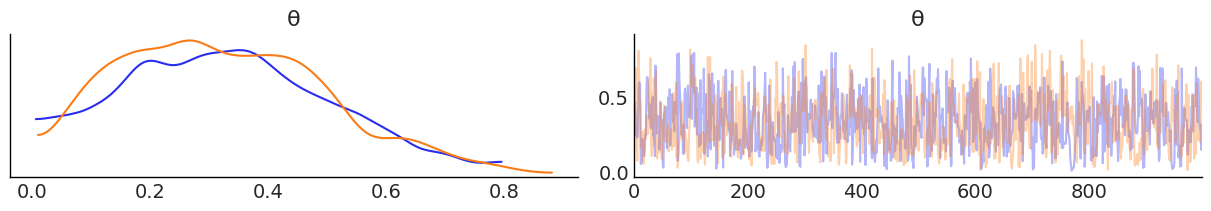

In [5]:
az.plot_trace(trace);

By using `az.plot_trace`, we get two subplots for each unobserved variable. The only unobserved variable in `our_first_model` is $\theta$. Notice that $y$ is an observed variable representing the data; we do not need to sample that because we already know those values.

In the above figure, we have two subplots. On the left, we have a Kernel Density Estimation (KDE) plot; this is like the smooth version of an histogram. On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values of the parameters according to the posterior distribution.

Another plot we can make with ArviZ is a posterior plot.

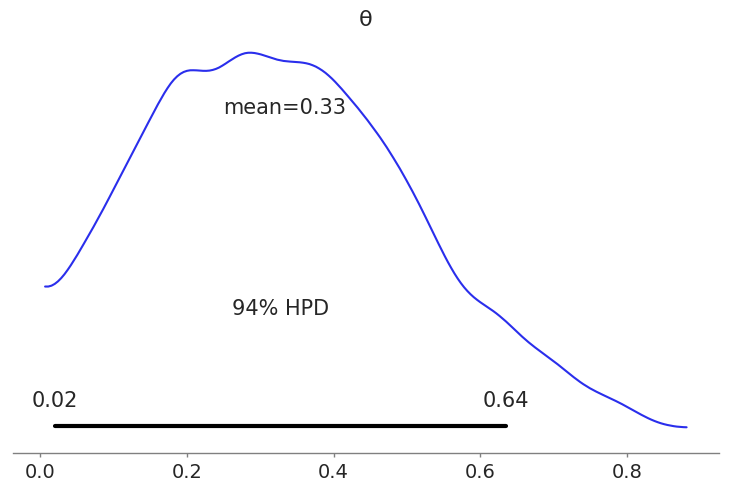

In [6]:
az.plot_posterior(trace, round_to=2);

We can interpret this result as follows, on average the value of $\theta$ is 0.33, this means the coin is most likely biased towards tails, as we used 0 to represent tails and 1 to represents heads. This estimation is pretty close to the real value of $\theta=0.35$, the value we used to generate the synthetic data. We can see that PyMC3 and our model has provided a reasonable answer. Of course for real examples we do not know the _true_ value of the parameters, that's the whole point of doing inferences in the first place.

As we can see from this example we did not got a single number for $\theta$ we got a distribution of plausible values. This distribution represents the uncertainty in our estimate. There are many ways to express the uncertainty of a Bayesian Analysis one is to use a **Highest Posterior Density** (HPD) Interval, as in the previous plot. For this particular example the hpd interval says that the 94% of the plausible values are contained within the 0.02-0.64 range.

Getting the posterior is not the end on a Bayesian Analysis. As with other forms of modeling a Bayesian analysis is an iterative process and is motivated by a particular context and set of questions. But I hope this simple example has make you learn more about Bayesian Analysis